How to Organize the Single Notebook (project_final.ipynb)
Each major section should have a large Markdown heading (#) followed by code cells.


Section Title (Markdown)	What goes inside
 1. Introduction	Problem statement, project goals
 2. Imports & Setup	All import statements and helper functions
 3. Data Exploration (EDA)	Load CSVs, check missing files, plot distributions
 4. Data Preparation	Train/Val/Test split, normalization, dataset class
 5. Model Building	Define baseline CNN model (later extend if needed)
 6. Training Loop	Training code, save best model
 7. Evaluation	Confusion matrix, classification report, plots
 8. Error Analysis	Misclassified samples, Grad-CAM (optional)
 9. Final Judgement	Pick best model, justify choice
 10. Independent Evaluation	Compare your results with literature
 11. Conclusion	Wrap up and future directions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#torch
import torch
from torch import nn

#torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix, BinaryAccuracy, MulticlassAccuracy
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold

import random
from PIL import Image
from pathlib import Path
from torchinfo import summary
import copy

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data Exploration

In [4]:
base_dir = os.getcwd()
image_dir = os.path.join(base_dir,'data','patch_images')
labels_main_dir = os.path.join(base_dir,"data","data_labels_mainData.csv")

In [5]:
labels_main = pd.read_csv(labels_main_dir)
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [6]:
labels_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [7]:
labels_main['imagePath'] = labels_main['ImageName'].apply(lambda x: os.path.join(image_dir,x))
labels_main['imageExists'] = labels_main['imagePath'].apply(lambda x: os.path.exists(x))
labels_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath,imageExists
0,22405,1,22405.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
1,22406,1,22406.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
2,22407,1,22407.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
3,22408,1,22408.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True
4,22409,1,22409.png,fibroblast,0,0,/Users/poornagunawardana/Desktop/Semester_4/CM...,True


In [8]:
print(labels_main.imageExists.value_counts())

imageExists
True    9896
Name: count, dtype: int64


In [9]:
print(f"Unique values in 'cellTypeName' :{labels_main.cellTypeName.unique()}")
print(f"Unique values in 'cellType' \t:{labels_main.cellType.unique()}")
print(f"Unique values in 'isCancerous \t:{labels_main.isCancerous.unique()}")

Unique values in 'cellTypeName' :['fibroblast' 'inflammatory' 'others' 'epithelial']
Unique values in 'cellType' 	:[0 1 3 2]
Unique values in 'isCancerous 	:[0 1]


In [10]:
print(f"No of patients :{labels_main.patientID.nunique()}")

No of patients :60


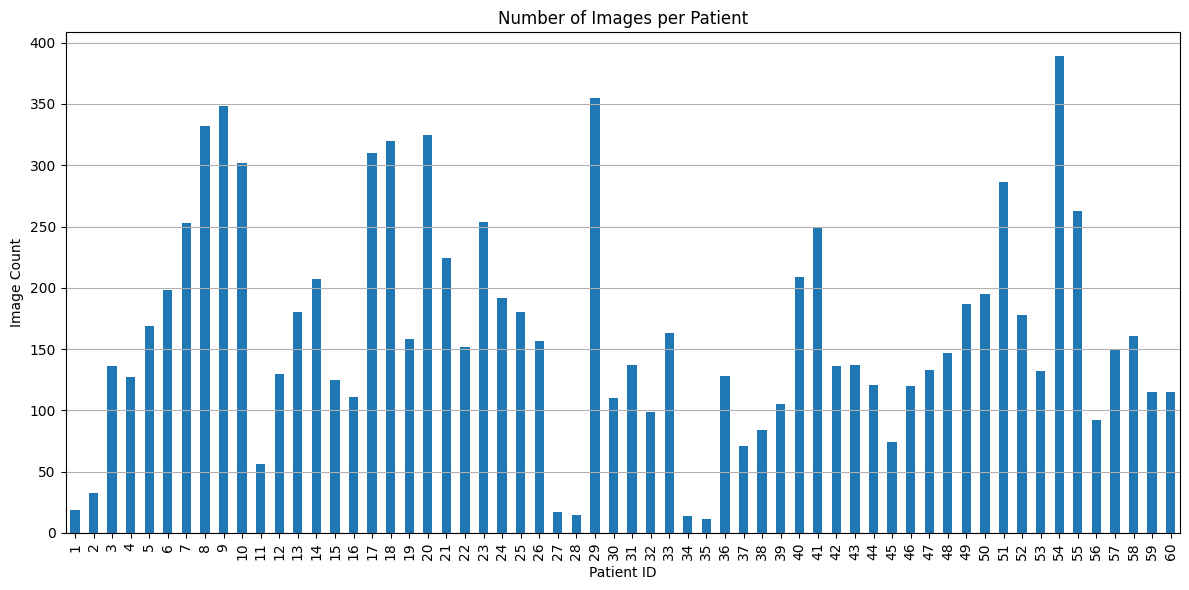

In [11]:
patient_image_counts = pd.DataFrame(labels_main.patientID.value_counts().sort_index())

patient_image_counts.plot(kind='bar', legend=False, figsize=(12, 6))
plt.title('Number of Images per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Image Count')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [12]:
print(labels_main[['cellTypeName', 'cellType']].drop_duplicates().sort_values(by='cellType'))

     cellTypeName  cellType
0      fibroblast         0
11   inflammatory         1
449    epithelial         2
17         others         3


   cellTypeName  Raw_count  Raw_proportion
0    epithelial       4079            41.2
1  inflammatory       2543            25.7
2    fibroblast       1888            19.1
3        others       1386            14.0


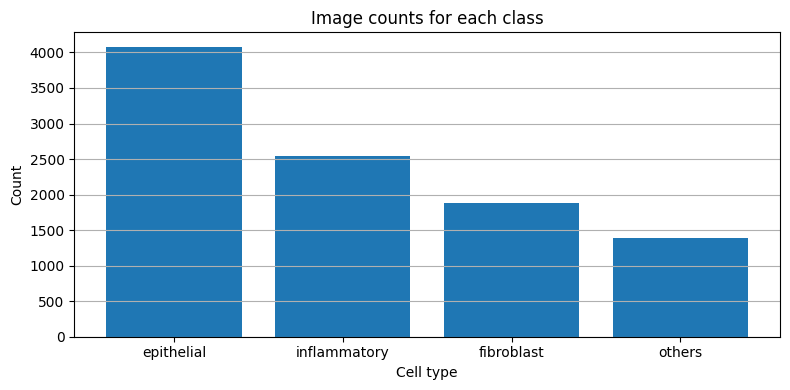

In [13]:
cellType_counts = labels_main['cellTypeName'].value_counts().reset_index()
cellType_counts.columns = ['cellTypeName', 'Raw_count']
cellType_counts['Raw_proportion'] = round((cellType_counts['Raw_count'] / cellType_counts['Raw_count'].sum()) * 100, 1)

print(cellType_counts)

plt.figure(figsize=[8,4])
plt.bar(cellType_counts['cellTypeName'],cellType_counts['Raw_count'])
plt.title('Image counts for each class')
plt.xlabel('Cell type')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In [14]:
patient_cellType = labels_main.groupby(['patientID', 'cellTypeName']).size().unstack(fill_value=0)
patient_cellType.head()

cellTypeName,epithelial,fibroblast,inflammatory,others
patientID,,,,
1,0,11,6,2
2,0,8,18,7
3,0,53,73,10
4,0,39,81,7
5,35,25,103,6


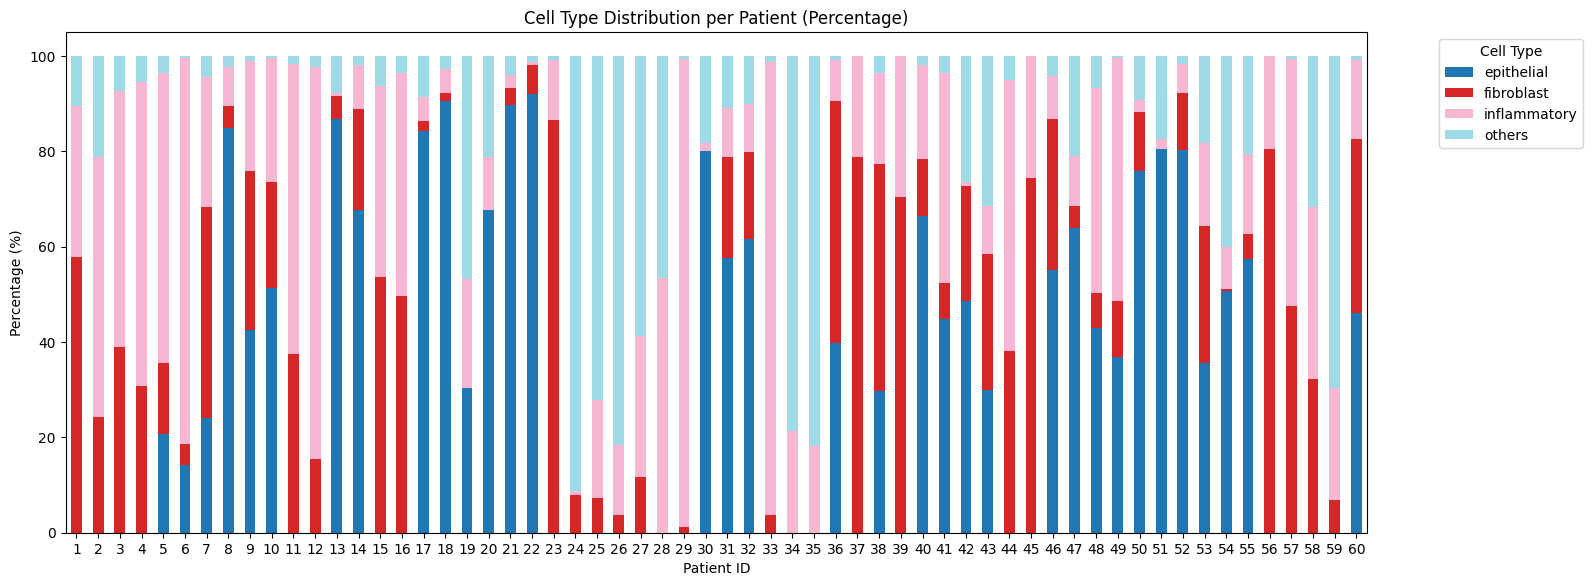

In [15]:
cell_percentages = patient_cellType.div(patient_cellType.sum(axis=1), axis=0) * 100

# Sort by patient ID for consistent plotting
cell_percentages = cell_percentages.sort_index()

# Plot
cell_percentages.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    colormap='tab20'
)

plt.ylabel("Percentage (%)")
plt.xlabel("Patient ID")
plt.title("Cell Type Distribution per Patient (Percentage)")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [16]:
# explore how the cell type distribution varies with the being a cencerous cell or not

In [17]:
y = labels_main["cellType"]      
groups = labels_main["patientID"]      

# first split for test data
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=24)  

train_val_idx, test_idx = next(sgkf.split(labels_main, y, groups))               # take the first fold as test
df_train_val = labels_main.iloc[train_val_idx].reset_index(drop=True)
df_test      = labels_main.iloc[test_idx]     .reset_index(drop=True)

# second split for val data
y_tv      = df_train_val["cellType"]
groups_tv = df_train_val["patientID"]

sgkf_val = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=24)   # 1/4 ≈ 25 % of train_val ⇒ 20 % overall
train_idx, val_idx = next(sgkf_val.split(df_train_val, y_tv, groups_tv))

df_train = df_train_val.iloc[train_idx].reset_index(drop=True)
df_val   = df_train_val.iloc[val_idx].reset_index(drop=True)

In [18]:
# ▶ 3. Sanity checks ────────────────────────────────────────────────────────
def show_split_stats(name, dframe):
    print(f"{name:5}  patients={dframe['patientID'].nunique():3}  samples={len(dframe):5}")
    print(dframe["cellTypeName"].value_counts(normalize=True).mul(100).round(1), "\n")

for split_name, split_df in [("TRAIN", df_train), ("VAL", df_val), ("TEST", df_test)]:
    show_split_stats(split_name, split_df)

TRAIN  patients= 33  samples= 5772
cellTypeName
epithelial      36.1
inflammatory    29.1
fibroblast      20.1
others          14.7
Name: proportion, dtype: float64 

VAL    patients= 13  samples= 1927
cellTypeName
epithelial      54.7
inflammatory    21.7
fibroblast      12.7
others          10.9
Name: proportion, dtype: float64 

TEST   patients= 14  samples= 2197
cellTypeName
epithelial      42.8
fibroblast      22.1
inflammatory    20.3
others          14.8
Name: proportion, dtype: float64 



In [19]:
def show_split_counts(name, dframe):
    print(f"{name:5}  patients={dframe['patientID'].nunique():3}  samples={len(dframe):5}")
    print(dframe["cellTypeName"].value_counts(), "\n")

for split_name, split_df in [("TRAIN", df_train), ("VAL", df_val), ("TEST", df_test)]:
    show_split_counts(split_name, split_df)

TRAIN  patients= 33  samples= 5772
cellTypeName
epithelial      2085
inflammatory    1679
fibroblast      1159
others           849
Name: count, dtype: int64 

VAL    patients= 13  samples= 1927
cellTypeName
epithelial      1054
inflammatory     418
fibroblast       244
others           211
Name: count, dtype: int64 

TEST   patients= 14  samples= 2197
cellTypeName
epithelial      940
fibroblast      485
inflammatory    446
others          326
Name: count, dtype: int64 



In [20]:
train_percentages = df_train['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
train_percentages.columns=['cellTypeName','Train_proportion']
cellType_counts = cellType_counts.merge(train_percentages,left_on='cellTypeName',right_on='cellTypeName')

val_percentages = df_val['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
val_percentages.columns=['cellTypeName','Val_proportion']
cellType_counts = cellType_counts.merge(val_percentages,left_on='cellTypeName',right_on='cellTypeName')

test_percentages = df_test['cellTypeName'].value_counts(normalize=True).mul(100).round(1).reset_index()
test_percentages.columns=['cellTypeName','Test_proportion']
cellType_counts =  cellType_counts.merge(test_percentages,left_on='cellTypeName',right_on='cellTypeName')

cellType_counts
                                    

,cellTypeName,Raw_count,Raw_proportion,Train_proportion,Val_proportion,Test_proportion
0,epithelial,4079,41.2,36.1,54.7,42.8
1,inflammatory,2543,25.7,29.1,21.7,20.3
2,fibroblast,1888,19.1,20.1,12.7,22.1
3,others,1386,14.0,14.7,10.9,14.8


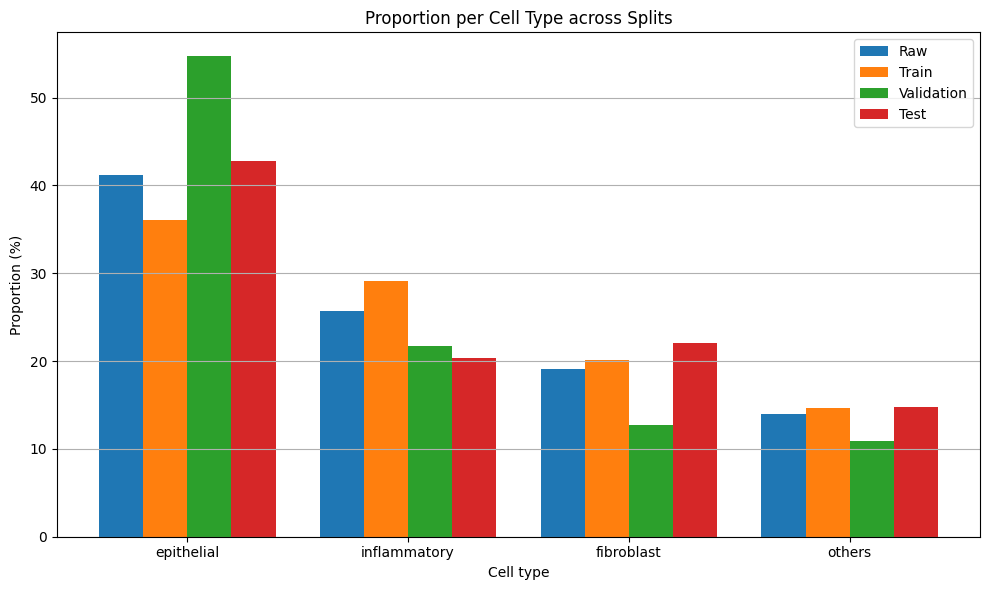

In [21]:
# Assume your dataframe is called df
categories = cellType_counts['cellTypeName']
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group
ax.bar(x - width*1.5, cellType_counts['Raw_proportion'], width, label='Raw')
ax.bar(x - width/2, cellType_counts['Train_proportion'], width, label='Train')
ax.bar(x + width/2, cellType_counts['Val_proportion'], width, label='Validation')
ax.bar(x + width*1.5, cellType_counts['Test_proportion'], width, label='Test')

# Labels and title
ax.set_xlabel('Cell type')
ax.set_ylabel('Proportion (%)')
ax.set_title('Proportion per Cell Type across Splits')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

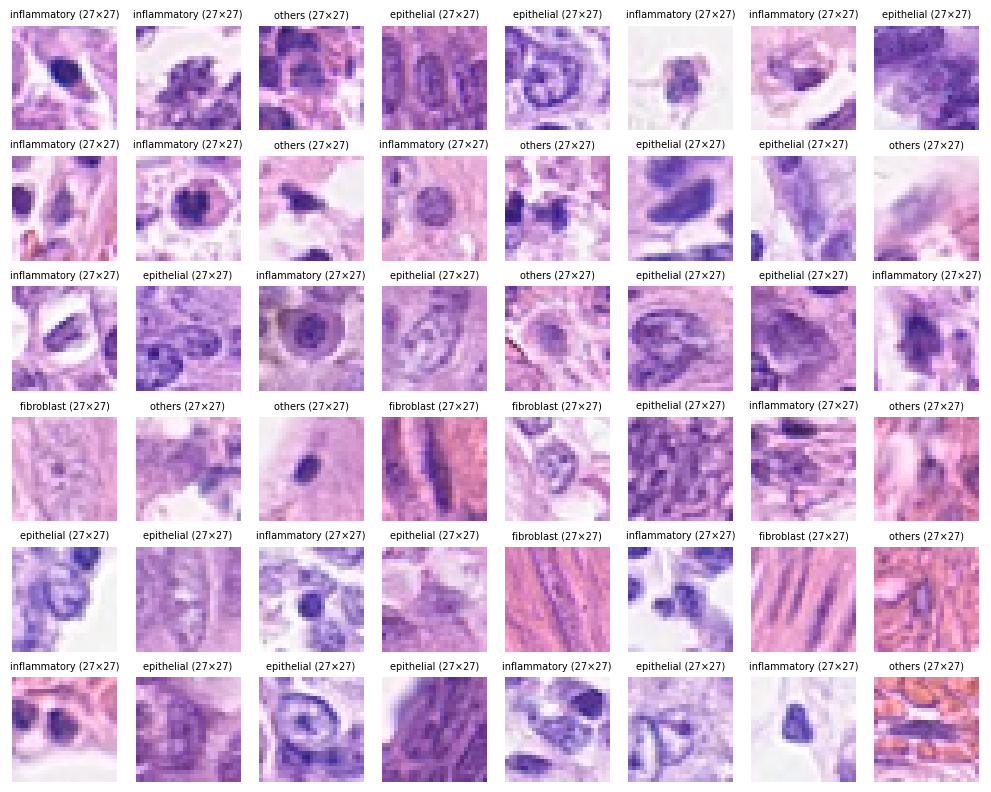

In [22]:
# visualize random set of images with cell type label and image sizes

# randomly select 54 images
sampled_df = labels_main.sample(n=54, random_state=42).reset_index(drop=True)

image_dir = Path('data/patch_images')

# plot
rows = 6
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(10, 8)) 
for ax, (_, row) in zip(axes.flatten(), sampled_df.iterrows()):
    img_path = image_dir / row['ImageName']
    
    img = Image.open(img_path)
    width, height = img.size
    ax.imshow(img)
    ax.set_title(f"{row['cellTypeName']} ({width}×{height})", fontsize=7)
    
    ax.axis('off')

plt.tight_layout()
plt.show()

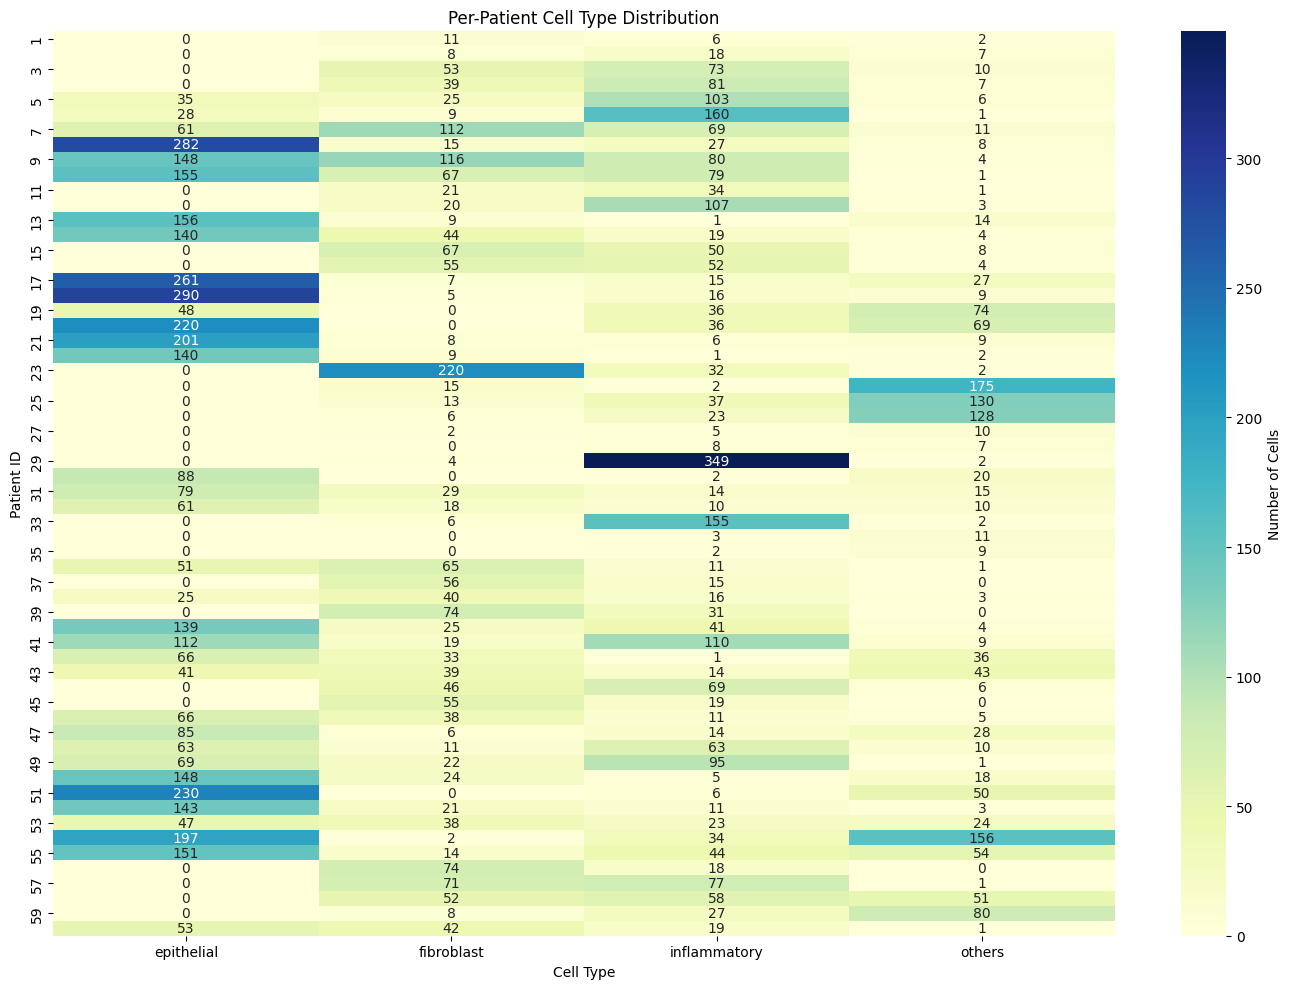

In [23]:
pivot_table = labels_main.pivot_table(index='patientID', 
                             columns='cellTypeName', 
                             values='ImageName', 
                             aggfunc='count', 
                             fill_value=0)

# ▶ 3. Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, 
            annot=True, 
            fmt="d", 
            cmap="YlGnBu", 
            cbar_kws={'label': 'Number of Cells'})

plt.title('Per-Patient Cell Type Distribution')
plt.xlabel('Cell Type')
plt.ylabel('Patient ID')
plt.tight_layout()
plt.show()

In [24]:
class ColonCellDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['imagePath']).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = row['cellType']
        return image, label


In [25]:
# function to calculate mean and standard deviation of train images

def get_mean_std(train_data):
    total_images= 0
    mean = torch.zeros(3)
    std = torch.zeros(3)

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    dataset = ColonCellDataset(train_data, transform=transform)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)


    for images, _ in tqdm(loader,total=len(loader)):

        batch_size, num_channels, height, width = images.shape
        total_images += batch_size

        # Sum mean and std per channel
        mean += images.mean(dim=(0, 2, 3)) * batch_size
        std += images.std(dim=(0, 2, 3)) * batch_size

    mean /= total_images
    std /= total_images

    return mean, std

In [26]:
# calculating mean and standard diviation for train dataset
train_data_mean, train_data_std = get_mean_std(df_train)

print(f"Mean of train dataset : {train_data_mean}")
print(f"Standard deviation of train dataset : {train_data_std}")

100%|██████████| 46/46 [00:00<00:00, 59.16it/s]

Mean of train dataset : tensor([0.7617, 0.5884, 0.8002])
Standard deviation of train dataset : tensor([0.1533, 0.1738, 0.1080])


In [27]:
# Train-time: add augmentation
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std)
# ])

# baseline transform for train dataset
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])

# baseline trainsfor for validation dataset
val_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_data_mean.tolist(), std=train_data_std.tolist())
])

In [28]:
train_dataset = ColonCellDataset(df_train, transform=train_transform)
val_dataset   = ColonCellDataset(df_val, transform=val_transform)
test_dataset  = ColonCellDataset(df_test, transform=val_transform)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=0)


In [30]:
print(f"No of batches in train data loader = {len(train_loader)}")
print(f"No of batches in val data loader = {len(val_loader)}")
print(f"No of batches in test data loader = {len(test_loader)}")

No of batches in train data loader = 46
No of batches in val data loader = 16
No of batches in test data loader = 18


In [31]:
# observing batch shape and several labels for one batch in train loader
images, labels = next(iter(train_loader))

print(f"Shape of a batch : {images.shape}")  
print(f"Sample labels for first 5 images of that batch : {labels[:5]}")    


Shape of a batch : torch.Size([128, 3, 64, 64])
Sample labels for first 5 images of that batch : tensor([2, 0, 1, 1, 1])


In [32]:
# temporary creating a subset to ensure the pipeline working properly

from torch.utils.data import Subset

small_train_dataset = Subset(train_dataset, range(100))
small_val_dataset = Subset(val_dataset,range(50))

small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True, num_workers=0)
small_val_loader = DataLoader(small_val_dataset,batch_size=16,num_workers=0)

In [33]:
# CNN model architecture 

class CNNModel(nn.Module):

  def __init__(self):
    super().__init__()

    # Convolutional Block 1
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)    
    )

    # Convolutional Block 2
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Convolutional Block 3
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


    # Fully connected layers
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=128*8*8,
                  out_features=4)
    )

  def forward(self, x: torch.Tensor):
        # x = self.conv_block1(x)
        # print(x.shape)
        # x = self.conv_block2(x)
        # print(x.shape)
        # x = self.conv_block3(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.conv_block3(self.conv_block2(self.conv_block1(x)))) 

In [34]:
model_0 = CNNModel().to(device)

In [35]:
# images, labels = next(iter(small_train_loader))

# images.shape

# # model_0(images)

# img_single, label_single = images[0].unsqueeze(dim=0), labels[0]
# print(f"Single image shape: {img_single.shape}\n")

# model_0.eval()
# with torch.inference_mode():
#     pred = model_0(img_single.to(device))

In [36]:
# summary(model_0,input_size=[1,3,64,64])

In [37]:
#  function to train and valiadation

def train_model(model, train_data, val_data, loss_function, optimizer, accuracy_function, epoch_count, early_stop, device):

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = [] 

  best_loss = float('inf')
  best_model_weights = None
  counter = early_stop

  for epoch in tqdm(range(epoch_count),total=epoch_count):

    #training
    model.train()

    total_train_loss = 0
    total_train_accuracy = 0

    for images, labels in train_data:

      images = images.to(device)
      labels = labels.to(device)

      predictions = model(images)
      loss = loss_function(predictions, labels)
      accuracy = accuracy_function(torch.argmax(predictions, dim=1),labels)

      total_train_loss += loss.item()*images.size(0)
      total_train_accuracy += accuracy.item()*images.size(0)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

    avg_train_loss = total_train_loss/len(train_data.dataset)
    avg_train_accuracy = total_train_accuracy/len(train_data.dataset)

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    #validation
    model.eval()

    total_val_loss = 0
    total_val_accuracy = 0

    val_predictions = []
    val_targets = []

    with torch.inference_mode():
      for images, labels in val_data:

        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        loss = loss_function(predictions, labels)
        predictions = torch.argmax(predictions, dim=1)
        accuracy = accuracy_function(predictions,labels)

        val_predictions.append(predictions.cpu())
        val_targets.append(labels.cpu())

        total_val_loss += loss.item()*images.size(0)
        total_val_accuracy += accuracy.item()*images.size(0)
        # print(f"accuracy {accuracy.item()}")
        # print(f"image size : {images.size(0)}")

      avg_val_loss = total_val_loss/len(val_data.dataset)
      avg_val_accuracy = total_val_accuracy/len(val_data.dataset)
      # print(f"total val accuracy : {total_val_accuracy}")
      # print(f"dataset size : {len(val_data.dataset)}")

      val_losses.append(avg_val_loss)
      val_accuracies.append(avg_val_accuracy)

      val_predictions = torch.cat(val_predictions)
      val_targets = torch.cat(val_targets)

      
      if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = early_stop
      else:
        counter -= 1
        if counter == 0:
          print("Early stopping")
          break


    print("-"*100)
    print(f"Epoch : {epoch+1}")
    print(f"Train loss : {avg_train_loss:.4f} \t| Train accuracy {avg_train_accuracy:.4f}")
    print(f"Val loss : {avg_val_loss:.4f} \t| Val accuracy {avg_val_accuracy:.4f}\n")

  return train_losses, train_accuracies, val_losses, val_accuracies, val_predictions, val_targets

In [38]:
def plot_loss_and_accuracy(train_losses, train_accuracies, val_losses, val_accuracies , figure_name):

    plt.figure(figsize=(15, 5))
  
    plt.subplot(1,2,1)
    plt.plot(train_losses,label="Train loss")
    plt.plot(val_losses,label="Validation loss")
    plt.xlabel("No of epoches")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.grid(axis='x')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accuracies,label="Train accuracy")
    plt.plot(val_accuracies,label="Validation accuracy")
    plt.xlabel("No of epoches")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.grid(axis='x')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{figure_name}.png")
    # plt.close()

In [39]:
def plot_confusion_metrics(predictions, target, figure_name=None):

  cm_metric = MulticlassConfusionMatrix(num_classes=4)
  cm = cm_metric(predictions,target)
  cm = cm.numpy()

  #plot
  plt.figure(figsize=(8, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
              xticklabels=["fibroblast", "inflammatory","epithelial","others"], 
              yticklabels=["fibroblast", "inflammatory","epithelial","others"])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [40]:
# classification report
class_names = ["fibroblast", "inflammatory","epithelial","others"]
def evaluate_per_class_metrics(val_targets, val_predictions, class_names=class_names):
    print("Classification Report:\n")
    report = classification_report(val_targets, val_predictions, target_names=class_names, digits=3)
    print(report)

In [41]:
# calculating macro accuracy
from sklearn.metrics import confusion_matrix

def macro_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    macro_acc = np.mean(per_class_accuracy)
    print(f"Macro Accuracy: {macro_acc:.3f}")


In [42]:
# defining loss function and  optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

# accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=4, average='macro').to(device)


In [43]:
train_losses, train_accuracies, val_losses, val_accuracies, val_predictions, val_targets = train_model(
                                                                                        model=model_0,
                                                                                        train_data=train_loader,
                                                                                        val_data=val_loader,
                                                                                        loss_function=loss_fn,
                                                                                        optimizer=optimizer,
                                                                                        accuracy_function=acc_fn,
                                                                                        epoch_count=5,
                                                                                        early_stop=5,
                                                                                        device=device)

 20%|██        | 1/5 [00:01<00:07,  1.96s/it]

----------------------------------------------------------------------------------------------------
Epoch : 1
Train loss : 0.9263 	| Train accuracy 0.5244
Val loss : 0.8061 	| Val accuracy 1133949368160605249208320.0000



 40%|████      | 2/5 [00:03<00:05,  1.78s/it]

----------------------------------------------------------------------------------------------------
Epoch : 2
Train loss : 0.7012 	| Train accuracy 0.6558
Val loss : 0.7393 	| Val accuracy 0.4394



 60%|██████    | 3/5 [00:05<00:03,  1.73s/it]

----------------------------------------------------------------------------------------------------
Epoch : 3
Train loss : 0.6364 	| Train accuracy 0.6951
Val loss : 0.8007 	| Val accuracy 0.4258



 80%|████████  | 4/5 [00:06<00:01,  1.71s/it]

----------------------------------------------------------------------------------------------------
Epoch : 4
Train loss : 0.5967 	| Train accuracy 0.7149
Val loss : 0.7687 	| Val accuracy 0.4309



100%|██████████| 5/5 [00:08<00:00,  1.74s/it]

----------------------------------------------------------------------------------------------------
Epoch : 5
Train loss : 0.5470 	| Train accuracy 0.7431
Val loss : 0.6999 	| Val accuracy 0.4588



In [44]:
0.1818*16+0.1538*16+0.4*16+2

13.7696

In [45]:
13.7696/50

0.275392

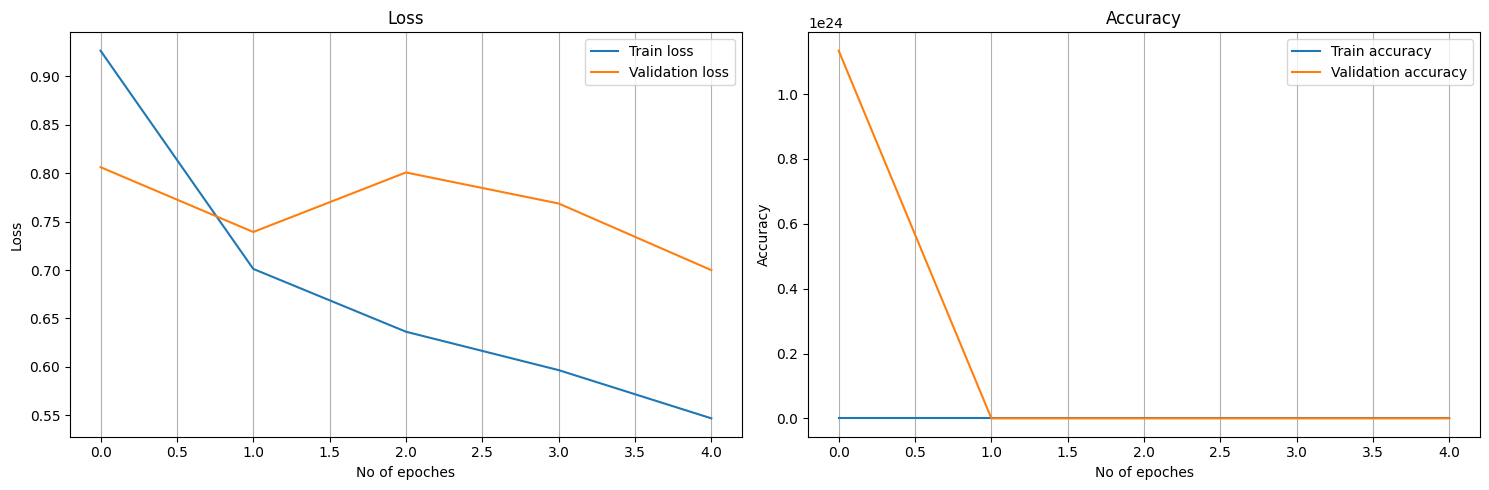

In [50]:
plot_loss_and_accuracy(train_losses, train_accuracies, val_losses, val_accuracies,figure_name="Base model")

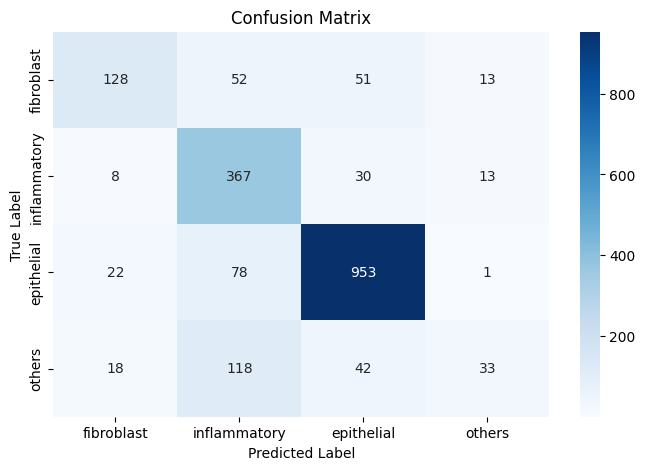

In [51]:
plot_confusion_metrics(val_predictions,val_targets)

In [52]:
evaluate_per_class_metrics(val_targets, val_predictions, class_names)


Classification Report:

              precision    recall  f1-score   support

  fibroblast      0.727     0.525     0.610       244
inflammatory      0.597     0.878     0.711       418
  epithelial      0.886     0.904     0.895      1054
      others      0.550     0.156     0.244       211

    accuracy                          0.769      1927
   macro avg      0.690     0.616     0.615      1927
weighted avg      0.766     0.769     0.747      1927



In [54]:
macro_accuracy(val_targets,val_predictions)


Macro Accuracy: 0.616
